In [1]:
'''
author: Yike Xie
data: 22/2/2023
content: correlate image features and transcriptome
'''

'\nauthor: Yike Xie\ndata: 22/2/2023\ncontent: correlate image features and transcriptome\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

#     print('filter genes')
#     sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    x = exp #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def get_correlation2(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    xw = exp #(39466, 10)
    yw = phe.values.T #(2, 10)

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata_s, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata_s.obs[fea]
            y = adata_s[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1), loc='upper left')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

def save_PC_frac_genes(corr, PC, fea, threshold):
    res = []

    for f in corr[fea].sort_values().unique():
        df_f = corr[(corr[fea] == f)]
        hmax = df_f[PC].quantile(threshold)
        hmin = df_f[PC].quantile(1 - threshold)

        ups = df_f[df_f[PC] >= hmax].index
        downs = df_f[df_f[PC] <= hmin].index

        feas = {
            fea: f,
            'up_genes': ups, 
            'down_genes': downs, 
            'hmax': hmax, 
            'hmin': hmin,
        }
        res.append(feas)

    res = pd.DataFrame(res)
    
    return res

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


Add features to adata


In [11]:
if True:
    # Average spectra among all channels
#     adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']
    
    print('Correlate with some simple features')
    # correlations between areas and gene expressions at single cell resolution
    feas = ['area', 'eccentricity']
    corr = get_correlation(adata, feas)
    corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 96
    corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)
    corr.to_csv(save_figures + 'correlation.tsv', sep='\t')

Correlate with some simple features


<ipython-input-3-3c4901f53b30>:40: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Text(0, 0.5, 'Cumulative over genes')

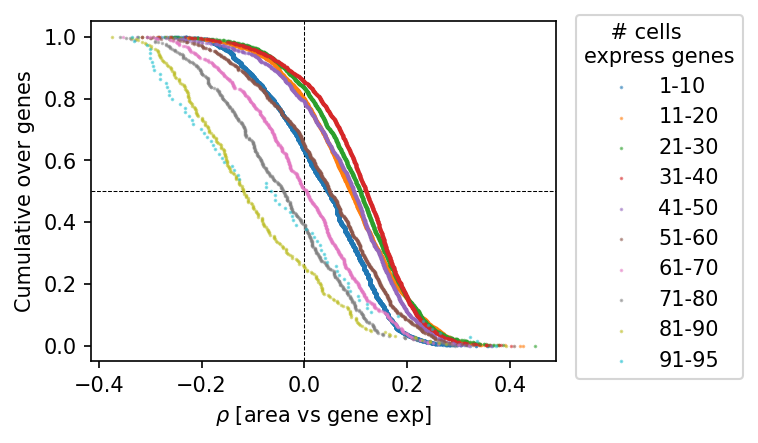

In [13]:
fea = 'area'

fig, ax = plt.subplots(figsize=[4, 3], dpi=150)
for i in range(0, 10):
    n1 = 1 + i * 10
    if i < 9:
        n2 = n1 + 10
    else:
        n2 = 96
    
    Rs = corr[corr['Number'].isin(range(n1, n2))][fea].tolist()
    x = list(np.sort(Rs))
    y = list(1.0 - np.linspace(0, 1, len(Rs)))
    
#     x = [min(Rs)] + x
#     y = [0] + y
    
    ax.scatter(x, y, label='{}-{}'.format(str(n1), str(n2-1)), s=0.5, alpha=0.5)
ax.legend(title='    # cells\nexpress genes', bbox_to_anchor=(1.02, 1.05), loc='upper left')
ax.axvline(0, ls='--', c='k', zorder=-5, lw=0.5)
ax.axhline(0.5, ls='--', c='k', zorder=-5, lw=0.5)

ax.set_xlabel(r'$\rho$ [{} vs gene exp]'.format('area'))
ax.set_ylabel('Cumulative over genes')

In [21]:
threshold = 0.95
pa = 'area'
res = save_PC_frac_genes(corr, pa, 'Number', threshold)

[Text(0.5, 0, '# cells expressing the gene'),
 Text(0, 0.5, '$\\rho$ [area vs gene exp]')]

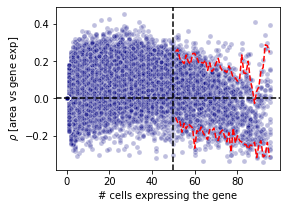

In [22]:
pa = 'area'

fig, ax = plt.subplots(figsize=[4, 3])
ax.scatter(corr['Number'], corr[pa], color='navy', edgecolor='white', alpha=0.25, s=25)
ax.axhline(0, c='k', ls='--')
ax.axvline(50, c='k', ls='--')
ax.plot(res['Number'][51:], res['hmax'][51:], c='red', ls='--')
ax.plot(res['Number'][51:], res['hmin'][51:], c='red', ls='--')
ax.set(xlabel='# cells expressing the gene', ylabel=r'$\rho$ [{} vs gene exp]'.format(pa))

In [5]:
print('filter genes')

corr = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/version2_96cells/correlation.tsv',
                  sep='\t', index_col=0)

# percentage of cells expressing this gene
pct = 0.8
gene_pct = pd.Series((adata.X > 0).sum(axis=0) / adata.obs.shape[0], index=adata.var_names)
high_pct = gene_pct[gene_pct >= pct].index

filter genes


In [22]:
df = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/version2_96cells/GSEAPY_area_neg300.tsv', 
                 sep='\t', index_col=0)
splicing_genes = df.loc[[2, 3, 4, 6]]['Genes'].str.split(';')
splicing_genes = np.unique(splicing_genes.iloc[0] + splicing_genes.iloc[1] + 
                           splicing_genes.iloc[2] + splicing_genes.iloc[3])
s_high = [gene for gene in splicing_genes if gene in high_pct]

In [27]:
# set threshold of cell number
df = corr[corr['Number'].isin(range(51, 100))]

In [41]:
a = ['SF3B4', 'PRMT5', 'SF3A1', 'PRPF19', 'U2SURP', 'SRRM1', 'HNRNPL',
'DDX39A', 'POLR2A', 'PCBP1', 'TRA2B', 'POLR2D', 'CSTF1', 'HNRNPC', 'SNRPA', 'SLC38A2']

# 'POLR2D', 'POLR2A', 'SF3B4', 'TRA2B', 'SLC38A2'

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


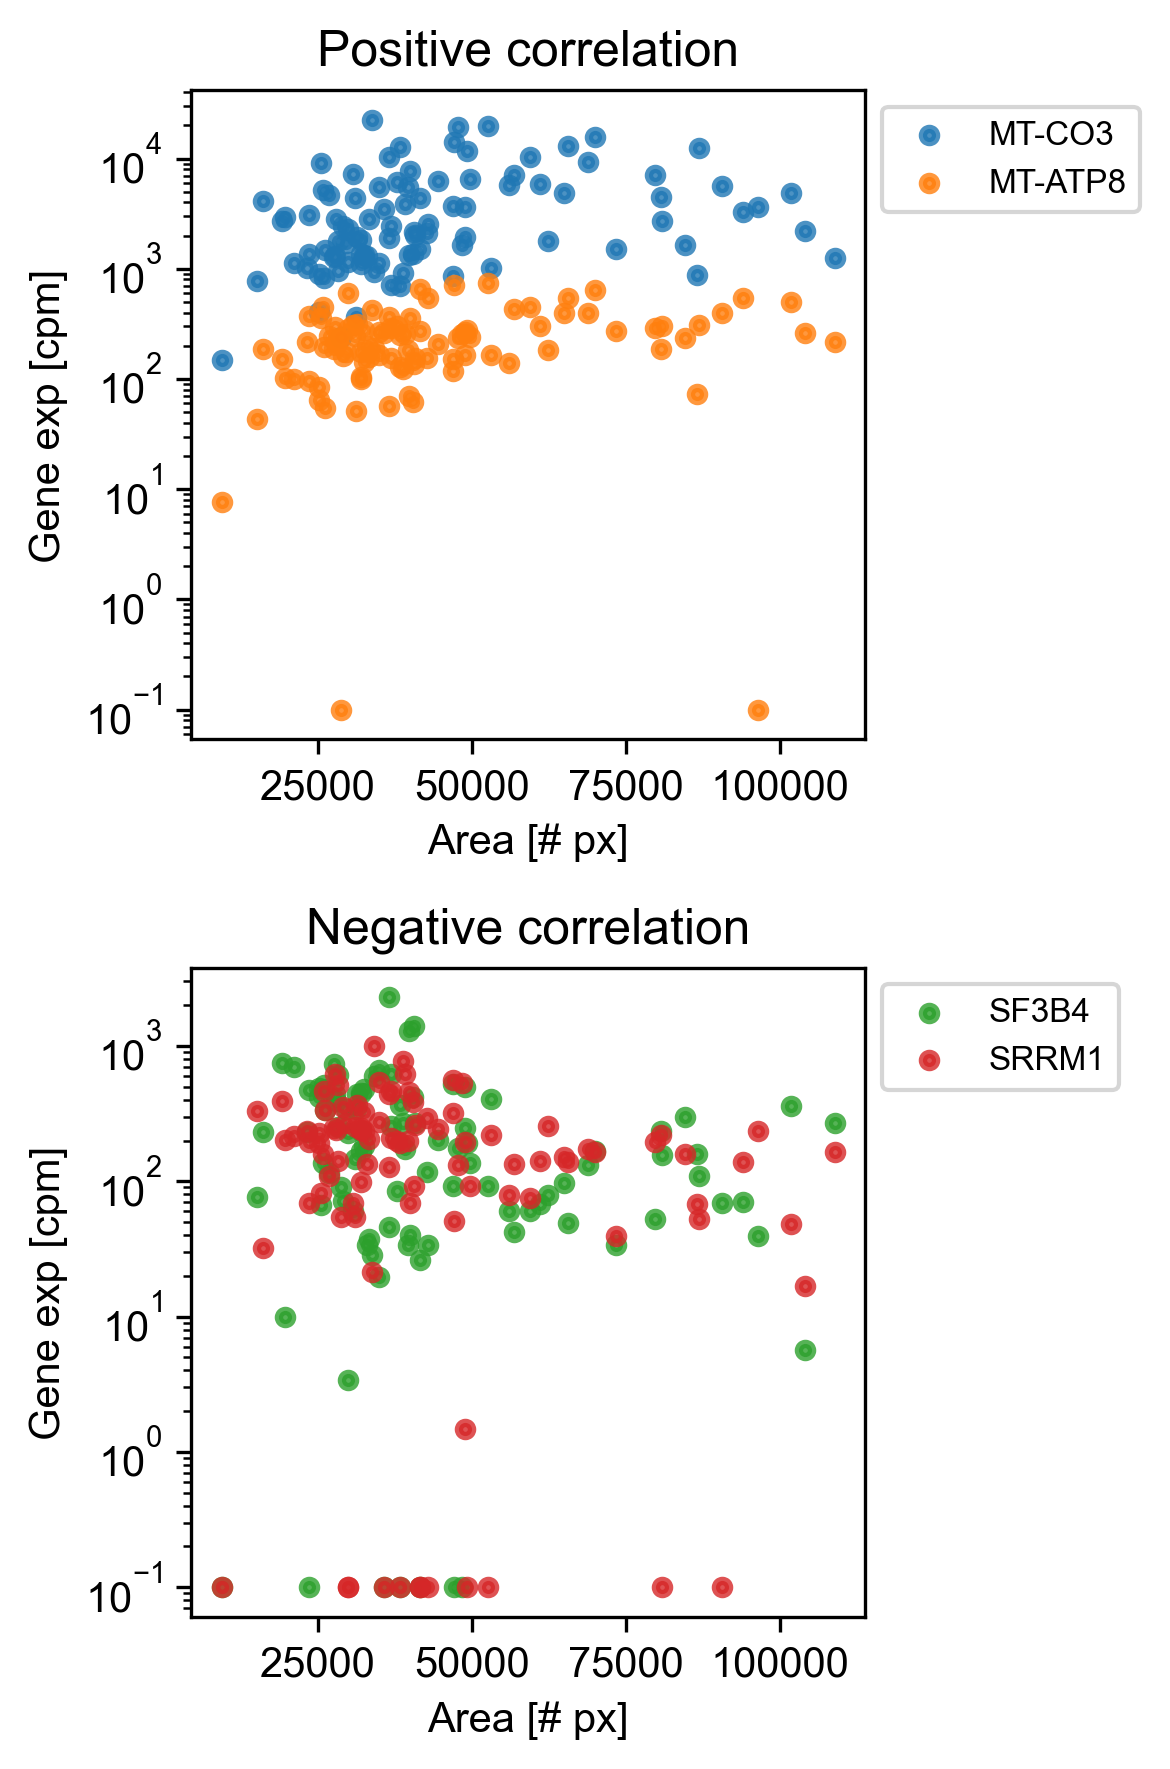

In [47]:
feas = ['area', ] #'eccentricity', 
xlabels = ['Area [# px]', ] # 'Eccentricity (y/x - 1)',

for fea, xlabel in zip(feas, xlabels):
    pos_genes = ['MT-CO3', 'MT-ATP8'] # df.nlargest(3, fea).index
    neg_genes = ['SF3B4', 'SRRM1'] # df.nsmallest(3, fea).index

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': pos_genes,
        'negative': neg_genes,
    }
    plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


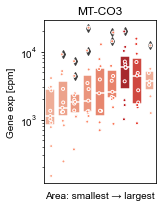

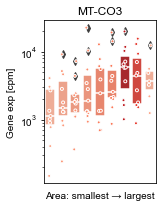

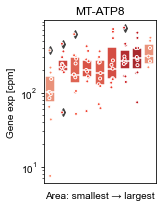

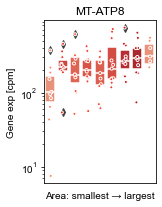

In [48]:
feas = ['area', ] # 'eccentricity'

for fea in feas:
    pos = ['MT-CO3', 'MT-ATP8']

    for gene in pos:
        cmap = 'Reds'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


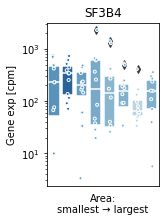

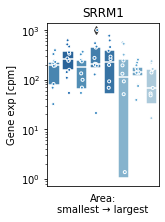

In [5]:
feas = ['area',]

for fea in feas:
#     negs = df.nsmallest(3, fea).index
    negs = ['SF3B4', 'SRRM1']

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)

### area pathway analysis

In [5]:
import gseapy as gp
from gseapy.plot import barplot

def gsea_analysis(genes, path, fn, title):
    res = gp.enrichr(gene_list=genes,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
    if fn is not False:
        res.res2d.to_csv(os.path.join(path, fn + '.tsv'), sep='\t')

    barplot(res.res2d, column='P-value', title=title, ofname=os.path.join(path, fn + '.svg')) 

In [97]:
pos300 = df['area'].fillna(0).sort_values()[-300:].index.tolist()
neg300 = df['area'].fillna(0).sort_values()[:300].index.tolist()

gsea_analysis(pos300, save_figures, 'GSEAPY_area_pos300', 'Pathways positively correlated with area')
gsea_analysis(neg300, save_figures, 'GSEAPY_area_neg300', 'Pathways negatively correlated with area')

In [99]:
import gseapy as gp
from gseapy.plot import barplot
pthw = gp.enrichr(gene_list=neg300,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05).res2d

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


In [102]:
pthw_plot = pthw[:10]
pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])

<ipython-input-102-dc940eca4eab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])


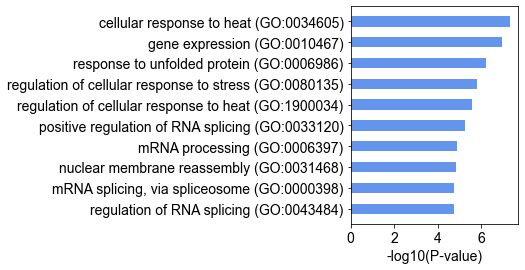

In [151]:
fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12

ax.barh(range(10), pthw_plot['-log10(P-value)'][::-1], height=0.5, color='cornflowerblue')
ax.set_yticks(range(10))

# yticklabels = ['{}:\n{}'.format(i[-12:][1:-1], i[:-13].capitalize()) 
#                for i in pthw_plot['Term'][::-1]]
ax.set_yticklabels(pthw_plot['Term'][::-1])

ax.set_xlabel('-log10(P-value)')
plt.savefig(save_figures + 'pos_genes_area_pathway.pdf', dpi=150, bbox_inches='tight')

### ratio of MT genes vs cell area

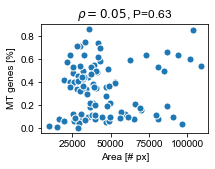

In [87]:
MT_genes = adata.var_names[adata.var_names.str.startswith('MT-')]
adata.obs['MT genes [%]'] = adata[:, MT_genes].X.sum(axis=1) / adata.X.sum(axis=1)

fig, ax = plt.subplots(figsize=[3, 2])
rcParams['pdf.fonttype'] = 42

ax.scatter(adata.obs['area'], adata.obs['MT genes [%]'], s=50, edgecolor='white')
ax.set_xlabel('Area [# px]')
ax.set_ylabel('MT genes [%]')

from scipy.stats import spearmanr
rho, P = spearmanr(adata.obs['area'], adata.obs['MT genes [%]'])
ax.set_title(r'$\rho={}$, P={}'.format(str(rho)[:4], str(P)[:4]))

plt.savefig(save_figures + 'MT_genes_area.pdf', dpi=150, bbox_inches='tight')

### eccentricity pathway analysis

In [23]:
pos300 = df['eccentricity'].fillna(0).sort_values()[-300:].index.tolist()
neg300 = df['eccentricity'].fillna(0).sort_values()[:300].index.tolist()

gsea_analysis(pos300, save_figures, 'GSEAPY_eccentricity_pos300', 
              'Pathways positively correlated with eccentricity')
gsea_analysis(neg300, save_figures, 'GSEAPY_eccentricity_neg300', 
              'Pathways negatively correlated with eccentricity')